## Initializing opencv haarcascade face detection network
https://github.com/opencv/opencv/tree/master/data/haarcascades

In [24]:
# imports necessary for the face detection network
import cv2
import os

In [25]:
# converts a loaded image into the correct format for the openCV face detection network
def convertImg(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# uses the FaceNet to localize faces in a picture
def faceNetLocalize(img, **kwargs):
    #parameters
    scaleFactor = kwargs.get('scaleFactor', 1.1)    # between 1.05 (quality) and 1.4 (speed) recommended (scale of the faces we search for)
    minNeighbors = kwargs.get('minNeighbors', 4)    # between 3 (quantity) and 6 (quality) recommended
    minSize = kwargs.get('minSize', (10, 10))       # min size of a face in the picture
    faceNet = kwargs.get('faceNet', init_faceNet()) # pretrained model from openCV
    
    # conversion and localization
    img_cvt = convertImg(img)
    return faceNet.detectMultiScale3(img_cvt, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=minSize, outputRejectLevels = True)

# initialize the network using openCV
def init_faceNet(**kwargs):
    path = kwargs.get('path', 'haarcascade_frontalface_default.xml')
    return cv2.CascadeClassifier(path)


In [26]:
#TODO: testing with different model types
#for example: eye model + larger bounding box towards the bottom

## Mask classifier

foundation: https://www.tensorflow.org/tutorials/load_data/images

In [27]:
# imports necessary for the mask classifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPool2D, Conv2D, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Sequential, losses as lfs
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras import utils, models

##### variables:

In [61]:
# some useful variables

batch_size = 32                             # the amount of images processed at once
img_size = (180, 180)                       # img_size in pixels
img_size_vgg = (224, 224)                   # the vgg network needs a fixed img_size
def_epochs = 11                                 # default epochs used in training - should be chosen wisely
imgs_path = os.path.join('..', 'img')       # path to the dataset
num_classes = 3                             # default number of classes/ labels

# String for the correct usage of predict()
correct_usage = ('correct usage: \n' 
                'predict(\'category\', [model], [labels], img_path=[img_path]) \n'
                'predict(\'probabilities\', [model], [labels], img_path=[img_path]) \n'
                'predict(\'detection\', [model], [labels], img_path=[img_path])\n'
                'predict(\'live_detection\', [model], [labels])'
                'optional parameter: img_size, default=(180,180)')

##### loading dataset:

In [29]:
# method to load the images
def load_dataset(**kwargs):
    # optional values
    imgs_path = kwargs.get('imgs_path', os.path.join('..', 'img'))
    img_size = kwargs.get('img_size', (180, 180))

    # initializing lists
    valid_images = [".jpg",".png",".jpeg",".JPG"]
    x=[]
    y=[]
    
    # loop over files in image directory
    for root, dirs, files in os.walk(imgs_path):
        for filename in files:
            end = os.path.splitext(filename)[1]
            if end.lower() not in valid_images:
                continue
            image = load_img(os.path.join(root, filename), target_size=img_size)
            image = img_to_array(image)
            
            label = os.path.join(root, filename).split(os.path.sep)[-2]
            
            x.append(image)
            y.append(label)
    
    # convert images and labels to arrays for further use
    x = np.array(x, dtype="float32")
    y = np.array(y)

    ## convert labels to ints from 0 ... len(labels)-1
    labels = []
    for i in range(len(y)):
        try:
            j = labels.index(y[i])
        except:
            labels.append(y[i])
            j = labels.index(y[i])
        y[i] = j
    y.astype(int)
    
    ## split dataset
    trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=3)

    ## one-hot encoding
    trainY = utils.to_categorical(trainY, num_classes)
    testY = utils.to_categorical(testY, num_classes)

    ## data augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    ## merge xs and ys
    train_batches = datagen.flow(trainX, trainY, batch_size=32, subset='training')
    test_batches  = datagen.flow(trainX, trainY, batch_size=32, subset='validation')
    
    return train_batches, test_batches, labels, testX, testY, trainX, trainY

### Model selection & Training

In [30]:
#Hypermodels
# we tried using them, but in the end, they were not useful enough

#https://www.analyticsvidhya.com/blog/2021/06/create-convolutional-neural-network-model-and-optimize-using-keras-tuner-deep-learning/
#https://www.tensorflow.org/tutorials/keras/keras_tuner

# hypermodel using the same layers as the basic_model
def basic_model_builder(hp):
  
    basic_model = Sequential([
        Conv2D(filters=hp.Int('c1_filter', min_value=32, max_value=256, step=16), kernel_size=hp.Choice('c1_kernel', values=[3,5]), activation='relu'),
        AveragePooling2D(pool_size=(7,7)),
        Flatten(name="flatten"),
        Dense(units=hp.Int('d1_units', min_value=32, max_value=512, step=32), activation="relu"),
        Dropout(0.2),#drops small confidences
        Dense(num_classes, activation="softmax")
    ])

    basic_model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss=lfs.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return basic_model

# hypermodel using the same layers as the small_model
def small_model_builder(hp):
  
    small_model = Sequential([
        Conv2D(filters=hp.Int('c1_filter', min_value=32, max_value=256, step=16), kernel_size=hp.Choice('c1_kernel', values=[3,5]), activation='relu'),
        Conv2D(filters=hp.Int('c2_filter', min_value=32, max_value=256, step=16), kernel_size=hp.Choice('c2_kernel', values=[3,5]), activation='relu'),
        MaxPool2D(pool_size=(3,3)),
        Flatten(name="flatten"),
        Dense(units=hp.Int('d1_units', min_value=32, max_value=512, step=32), activation="relu"),
        Dropout(0.2),#drops small confidences
        Dense(num_classes, activation="softmax")
    ])

    small_model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss=lfs.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return small_model

# utilization of the keras auto-tuner
def tune_model(model_builder, xs, ys):
    tuner = kt.RandomSearch(kt.applications.HyperResNet(input_shape=(180, 180, 3), classes=2), objective='val_loss', max_trials=5)
    tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3)
    tuner.search(xs, ys, epochs=50, validation_split=0.2)
    return tuner.get_best_hyperparameters(num_trials=1)[0], tuner

In [56]:

# function to select a model structure by name
def select_model(model_name, **kwargs):
    #optional parameters
    num_labels = kwargs.get('num_classes', num_classes) # number of labels: is necessary for a correct output on the last Dense layer

    # simplest model
    basic_model = Sequential()
    basic_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(180,180,3)))
    basic_model.add(AveragePooling2D(pool_size=(7,7)))
    basic_model.add(Flatten(name="flatten"))
    basic_model.add(Dense(128, activation="relu"))
    basic_model.add(Dropout(0.5)) #drops small confidences
    basic_model.add(Dense(num_labels, activation="softmax"))
    
    #more complicated model, utilizing 2 convolutional layers like the vgg - still very time-consuming in training
    small_model = Sequential()
    small_model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu', input_shape=(180,180,3)))
    small_model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
    small_model.add(MaxPool2D(pool_size=(3,3)))
    small_model.add(Flatten(name="flatten"))
    small_model.add(Dense(units=224, activation="relu"))
    small_model.add(Dropout(0.5))#drops small confidences
    small_model.add(Dense(num_labels, activation="softmax"))
    
    #smaller version of the "vgg_small_model"
    vgg_smaller_model=Sequential()
    vgg_smaller_model.add(Conv2D(64,(3,3),activation='relu',input_shape=(180,180,3)))
    vgg_smaller_model.add(MaxPool2D(2,2))
    vgg_smaller_model.add(Conv2D(128,(3,3),activation='relu'))
    vgg_smaller_model.add(MaxPool2D(2,2))
    vgg_smaller_model.add(Flatten())
    vgg_smaller_model.add(Dropout(0.5))
    vgg_smaller_model.add(Dense(120,activation='relu'))
    vgg_smaller_model.add(Dense(num_labels,activation='softmax'))
    
    # simpler version of the vgg model, utilizes only one convolutional layer at a time, before max-pooling
    # but keeps the general design of the vgg model
    vgg_small_model=Sequential()
    vgg_small_model.add(Conv2D(64,(3,3),activation='relu',input_shape=(img_size[0],img_size[1],3)))
    vgg_small_model.add(MaxPool2D(2,2))
    vgg_small_model.add(Conv2D(64,(3,3),activation='relu'))
    vgg_small_model.add(MaxPool2D(2,2))
    vgg_small_model.add(Conv2D(128,(3,3),activation='relu'))
    vgg_small_model.add(MaxPool2D(2,2))
    vgg_small_model.add(Conv2D(128,(3,3),activation='relu'))
    vgg_small_model.add(MaxPool2D(2,2))
    vgg_small_model.add(Flatten())
    vgg_small_model.add(Dropout(0.5))
    vgg_small_model.add(Dense(120,activation='relu'))
    vgg_small_model.add(Dense(num_labels,activation='softmax'))


    # the vgg model is a state of the art model design, we do not have the necessary power or training data to utilize this model
    vgg_model = Sequential()
    vgg_model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu", strides=(1,1))) 
    vgg_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    vgg_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    vgg_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(MaxPool2D(pool_size=(2, 2), strides=(2)))
    vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(MaxPool2D(pool_size=(2, 2), strides=(2)))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(MaxPool2D(pool_size=(2, 2), strides=(2)))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(MaxPool2D(pool_size=(2, 2), strides=(2)))
    vgg_model.add(Flatten())
    vgg_model.add(Dense(units=4096, activation="relu"))
    vgg_model.add(Dense(units=4096, activation="relu"))
    vgg_model.add(Dense(units=num_labels, activation="softmax"))
    

    # returns the correct model

    if model_name == 'basic_model':
        #basic_model.summary()
        return basic_model
    
    if model_name == 'small_model':
        #small_model.summary()
        return small_model

    if model_name == 'vgg_model':
        #vgg_model.summary()
        return vgg_model
    
    if model_name == 'vgg_small_model':
        #vgg_small_model.summary()
        return vgg_small_model
    
    if model_name == 'vgg_smaller_model':
        #vgg_smaller_model.summary()
        return vgg_smaller_model

about the VGG-model: https://neurohive.io/en/popular-networks/vgg16/

In [32]:
# train the model using the given dataset
def train_model(model, train_ds, val_ds, **kwargs):
    # optional parameter
    epochs = kwargs.get('epochs', def_epochs)   # training epochs
    
    # some loss functions we tested:
    # categorical_crossentropy
    # mean_squared_error
    # mean_squared_logarithmic_error
    
    # compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    # train/fit the model and save the history for documentation/ testing purposes
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return history

#### Testing/Evaluation (mask):
https://www.tensorflow.org/guide/keras/train_and_evaluate

In [33]:
# deprecated evaluation function, but could still be useful
def evaluate_model(x_test, y_test, model):
    y_pred_confidences = model.predict(x_test)
    y_pred = [np.argmax(cs) for cs in y_pred_confidences]
    print(classification_report(y_test, y_pred))

##### Load/ Save models

In [34]:
def save_model(path, model):
    model.save(path, save_format="h5")
    
def load_model_good(path):
    return models.load_model(path)

##### Predictions:

In [54]:
# returns the label with the highest confidence of a prediction
def maskPredict(model, img, labels):
    pred = model.predict(img[None])
    label_index = np.argmax(pred)
    print(labels[label_index])
    return labels[label_index], pred[0][label_index]


#mode can be 'category', 'probabilities', 'detection', 'live_detection'
def predict(mode, model, **kwargs):
    #model = kwargs.get('model', load_model())
    img_path = kwargs.get('img_path', None)
    img_size = kwargs.get('img_size', (180, 180))
    labels = kwargs.get('labels', None)
    
    # display the help menu 
    if mode=='help':
        print(correct_usage)
        return

    # change to live_detection and interpret camera feed
    if mode=='live_detection':
        live_det(model, img_size, labels)
        return
    
    # print help menu, as function was malused
    if img_path is None:
        print(correct_usage)
        return

    #load_img
    img = load_img(img_path, target_size = img_size)
    img = img_to_array(img)
    
    #change into detection mode
    if mode=='detection':
        detect(img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        return
        
    # change into category mode, printing the label of highest confidence
    if mode=='category':
        label, _ = maskPredict(model, img, labels)
        return label
        
    # change into probability mode, printing the probability for each label
    if mode=='probabilities':
        confidences = model.predict(img[None])[0]
        ret_str = ''
        for lab in range(len(labels)):
          ret_str = ret_str + (f"{labels[lab]}: {confidences[lab]}")
        return ret_str

    # no valid mode was specified: print help menu
    else:
        print(correct_usage)

# detect and classify a face on an image
def detect(model, img, img_size, labels):
    faceLocs, rejectLevels, confidences = faceNetLocalize(img)
        
    for (x, y, w, h) in faceLocs:
        #crop image and predict label of cropped image
        img_crop = img[y:y+w, x:x+h]
        img_crop = cv2.resize(img_crop, img_size)
        img_crop = img_crop / 255
        label, confidence_mask = maskPredict(model, img_to_array(img_crop), labels)

        #show label/ bounding box on image
        cv2.putText(img, f"{label}, confidence:{confidence_mask}", (x, y), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 2) 
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    
    cv2.imshow('live_output', img)

# detect and classify images from a live-feed
def live_det(model, img_size, labels):
    wait_time = 10 #time in ms to wait before refreshing feed
    camera = cv2.VideoCapture(0) #Input value might differ on different systems
    
    while(True):
        ret, img = camera.read()
        if not ret:
            print('Error: failed reading camera')
            return 'Error: failed reading camera'
        detect(model, img, img_size, labels)

        #wait for ESC or q
        if (cv2.waitKey(wait_time) & 0xFF) in [27, ord('q')]: 
            break

    camera.release()
    cv2.destroyAllWindows()
    return 'live_output'

## Testing, documentation, stuff ...

In [36]:
train_ds, test_ds, labels, testX, testY, trainX, trainY = load_dataset(img_size=img_size)
#bhps, tuner = tune_model(basic_model_builder, x_test, y_test)

In [37]:
model = select_model('vgg_small_model')
#model = tuner.hypermodel.build(bhps)
history = train_model(model, train_ds, test_ds, epochs=15)

#evaluate_model(testX, testY, model)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 178, 178, 64)      1792      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 89, 89, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 18, 18, 128)      

C:\Users\Julie\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Julie\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/15
8/8 [==============================] - 11s 1s/step - loss: 0.2268 - accuracy: 0.3837 - val_loss: 0.2138 - val_accuracy: 0.2787
Epoch 2/15
8/8 [==============================] - 9s 1s/step - loss: 0.2053 - accuracy: 0.4490 - val_loss: 0.1895 - val_accuracy: 0.5410
Epoch 3/15
8/8 [==============================] - 9s 1s/step - loss: 0.1691 - accuracy: 0.5796 - val_loss: 0.1543 - val_accuracy: 0.6393
Epoch 4/15
8/8 [==============================] - 9s 1s/step - loss: 0.1260 - accuracy: 0.7551 - val_loss: 0.1229 - val_accuracy: 0.7377
Epoch 5/15
8/8 [==============================] - 9s 1s/step - loss: 0.1245 - accuracy: 0.7265 - val_loss: 0.0791 - val_accuracy: 0.8361
Epoch 6/15
8/8 [==============================] - 9s 1s/step - loss: 0.1057 - accuracy: 0.7918 - val_loss: 0.1011 - val_accuracy: 0.7377
Epoch 7/15
8/8 [==============================] - 10s 1s/step - loss: 0.0969 - accuracy: 0.7878 - val_loss: 0.0712 - val_accuracy: 0.8525
Epoch 8/15
8/8 [=======================

In [38]:
print("loss =",history.history["loss"])
print("val_loss =",history.history["val_loss"])
print("acc =",history.history["accuracy"])
print("val_acc =",history.history["val_accuracy"])

loss = [0.22679203748703003, 0.2053389996290207, 0.16911639273166656, 0.12601663172245026, 0.12450552731752396, 0.1056663990020752, 0.0969032421708107, 0.08678758889436722, 0.08668801188468933, 0.06593577563762665, 0.0837370753288269, 0.08378680050373077, 0.06485350430011749, 0.07042436301708221, 0.037699684500694275]
val_loss = [0.2138388603925705, 0.1895151287317276, 0.15430901944637299, 0.12285609543323517, 0.07908414304256439, 0.10113456845283508, 0.07119423896074295, 0.06802776455879211, 0.04247521981596947, 0.08209511637687683, 0.06914598494768143, 0.046947333961725235, 0.05786660686135292, 0.04125593602657318, 0.0471620187163353]
acc = [0.38367345929145813, 0.44897958636283875, 0.5795918107032776, 0.7551020383834839, 0.7265306115150452, 0.7918367385864258, 0.7877551317214966, 0.8040816187858582, 0.8163265585899353, 0.8653061389923096, 0.8408163189888, 0.8367347121238708, 0.8653061389923096, 0.8571428656578064, 0.9306122660636902]
val_acc = [0.2786885201931, 0.5409836173057556, 0

In [39]:
print("loss =",history.history["loss"])
print("val_loss =",history.history["val_loss"])
print("acc =",history.history["accuracy"])
print("val_acc =",history.history["val_accuracy"])

loss = [0.22679203748703003, 0.2053389996290207, 0.16911639273166656, 0.12601663172245026, 0.12450552731752396, 0.1056663990020752, 0.0969032421708107, 0.08678758889436722, 0.08668801188468933, 0.06593577563762665, 0.0837370753288269, 0.08378680050373077, 0.06485350430011749, 0.07042436301708221, 0.037699684500694275]
val_loss = [0.2138388603925705, 0.1895151287317276, 0.15430901944637299, 0.12285609543323517, 0.07908414304256439, 0.10113456845283508, 0.07119423896074295, 0.06802776455879211, 0.04247521981596947, 0.08209511637687683, 0.06914598494768143, 0.046947333961725235, 0.05786660686135292, 0.04125593602657318, 0.0471620187163353]
acc = [0.38367345929145813, 0.44897958636283875, 0.5795918107032776, 0.7551020383834839, 0.7265306115150452, 0.7918367385864258, 0.7877551317214966, 0.8040816187858582, 0.8163265585899353, 0.8653061389923096, 0.8408163189888, 0.8367347121238708, 0.8653061389923096, 0.8571428656578064, 0.9306122660636902]
val_acc = [0.2786885201931, 0.5409836173057556, 0

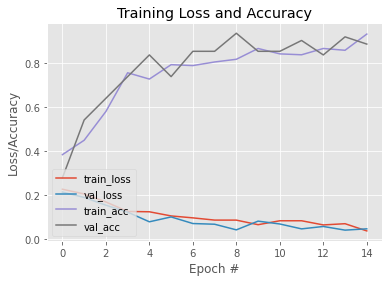

In [40]:
N = 15
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [55]:
img_path='../img/ffp2/IMG_1599.JPG_(350.0, 92.0, 1009.0, 599.0).png'
img_path='../img/no_mask/Foto 22.01.22, 19 02 46.jpg_(103.0, 94.0, 619.0, 848.0).png'
#img_path='../img/op_mask/IMG_1337.JPG_(878, 710, 954, 954).png'
#img_path='../img/other_mask/IMG_1327.JPG_(863, 476, 1097, 1097).png'
predict('probabilities',img_path=img_path,  model=model, labels=labels, img_size=(180,180))

#predict('live_detection', model=model, labels=labels, img_size=(180,180))

'ffp2: 0.0 \nno_mask: 1.0 \nop_mask: 0.0 \n'